# ASD Concrete Autoencoder
The objective of this notebook is to develop a **concrete autoencoder** that compresses our data into a significantly lower-dimensional space while retaining as much information as possible. The model should then be able to reconstruct the original data with minimal loss. We will evaluate our success by comparing the output of the autoencoder to its corresponding input—if they are similar, the autoencoder has effectively learned a compact representation of the data.
### Anatomy of an Autoencoder
Autoencoders have two major parts, the **encoder** and the **decoder**:

The *encoder* is the first half of the autoencoder, responsible for compressing the data in a way that allows the decoder to reconstruct it with minimal loss. In essence, the encoder seeks to learn an efficient representation of the data in a lower-dimensional latent space while preserving its essential structure.

The *decoder* then takes this compressed representation and attempts to reconstruct the data back to its original size, minimizing any loss of information. Its effectiveness depends on how well the encoder has captured the most important features of the data.
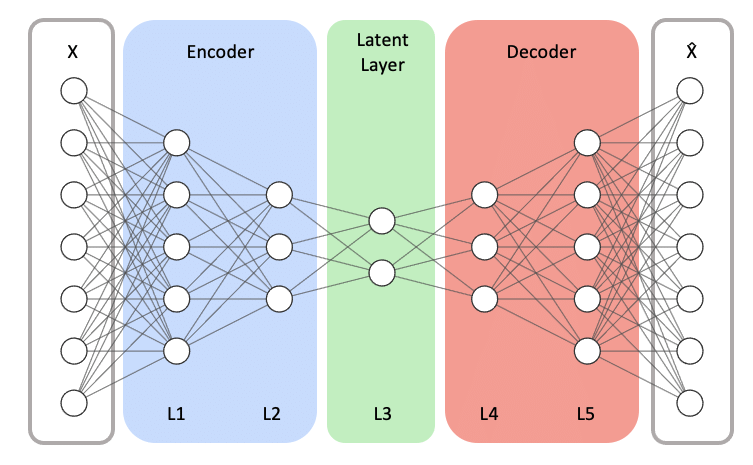

However, the autoencoder we're working with don’t rely on a series of fully connected layers for the encoder. Instead, we introduce a concrete selector layer that allows for a user-defined number of nodes, $k$. During training, this layer selects random linear combinations of input features, and as training progresses, it gradually focuses on a discrete set of $k$ features. This selective process is maintained even during testing.
## Determining the Size of the Latent Space
In the previous section, we discussed encoders, decoders, and the **latent space**—the compressed representation of our data with the smallest number of dimensions. But how do we determine the optimal size of this space?

One approach might be to pick a nice number like 10, 100, or 1000. A slightly more reasoned guess could be using a heuristic, such as $0.2 \times 19900 = 3980 \ dimensions$, claiming that it retains about $80\%$ of the information, contributed by only $20\%$ of the features. This inspired by Pareto’s principle.

But a more systematic approach, however, might be to use Principal Component Analysis (PCA) to determine the number of dimensions needed to preserve a chosen percentage of variance in the data. This allows us to make an informed decision rather than relying on arbitrary choices.
> **Important Note**: Often when using principal component analysis, after finding the principal components, we transform our data. We will not do that hear because we want our autoencoder to learn its own representation of the data. However, we can still use PCA to reason about how small we want that representation to be.

Principal Component Analysis (PCA) is a dimensionality reduction technique applied to continuous data that uses linear algebra techniques to project the data from a high-dimensional space into a lower-dimensional space. Principle Component Analysis accomplishes this by searching for new attributes (*principal components*) that are linear combinations of the original attributes, orthogonal to eachother, or capture the maximum variation in the data.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# return data with only indexes selected by the concrete selector
def index_selector(dataset, indices):
    return dataset[:, indices]

# read data into notebook
train = np.loadtxt("data_train.csv", delimiter=",")
indices = np.loadtxt(f"paper_indices.csv", delimiter=",").astype(int)  # indices from paper
indices = indices.astype(int)  # disallows floating point error later
train = index_selector(train, indices)

print(f"Length: {train.shape[1]}")

# find the number of principals components needed to preserve 80, 90, 95, and 99 percent of variance
pca = PCA()
pca.fit(train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

for percent in [80, 90, 95, 99]:
    print(f"{percent}% of variance can be captured by {np.argmax(cumsum >= percent/100) + 1} components")

The principal component analysis reveals that it is likely that we will be able to signifcantly reduce the dimensionality of our data. In fact, we can retain $99\%$ of the variance with only $883\ dimensions$. Additionally, if we are comfortable retaining only $80\%$ of the data we can reduce the dimensionality to only $427\ dimensions$- significantly fewer than the original $19900\ dimensions$ in our original data.

Reducing dimensionality not only simplifies the dataset but also makes training a machine learning model more efficient. Models trained on high-dimensional data are more prone to overfitting and require greater computational resources. By working with fewer dimensions, we can improve generalization, reduce training time, and mitigate the risk of the curse of dimensionality, which can negatively impact performance in high-dimensional spaces.

## Training an Autoencoder
Now informed with a ballpark estimate of the size that our latent space should be, we can attempt to build some autoencoders. We will use a simple metric to determine the quality of these encoders called loss. For autoencoders, the loss typically measures the difference between the input and the reconstructed output.

In [ ]:
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

# read data into notebook
test = np.loadtxt("data_test.csv", delimiter=",")
indices = np.loadtxt(f"paper_indices.csv", delimiter=",").astype(int)  # indices from paper
indices = indices.astype(int)  # disallows floating point error later
test = index_selector(test, indices)

n_features = train.shape[1]  # 9950

def decoder(x, training= False):
    # encoder
    # x = Dense(n_features, activation="linear")(x)
    # x = Dense(10000, activation="leaky_relu")(x)
    # x = Dense(5000, activation="leaky_relu")(x)
    # x = Dense(2500, activation="leaky_relu")(x)
    # x = Dense(1500, activation="leaky_relu")(x)
    # x = Dense(1000, activation="leaky_relu")(x)
    
    # x = Dense(800, activation="leaky_relu")(x)  # latent space
    
    # decoder
    # x = Dense(1000, activation="leaky_relu")(x)
    x = Dense(2000, activation="leaky_relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(4000, activation="leaky_relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(6000, activation="leaky_relu")(x)
    x = Dropout(0.2)(x)  # was 0.2
    x = Dense(8000, activation="leaky_relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(n_features, activation="linear")(x)
    return x


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        print("Memory growth enabled for GPUs.")
        k=2000  # TODO: try different values for this parameter 500 - 900
        selector = ConcreteAutoencoderFeatureSelector(
            K = k,
            output_function = decoder, 
            learning_rate=0.002,
            min_temp=0.01,
            num_epochs=6400,
            batch_size=12,  # batch_size was 17 (was 15 in previous run) now 12 because memory issues
            tryout_limit=1
        )
        selector.fit(train, train, test, test)
        # reconstruction_loss = selector.get_params().evaluate(x_test, x_test)
        reconstruction_loss = selector.get_params().evaluate(test, test)
        print(f"Loss: {reconstruction_loss}")
        results = open("res.csv",'a')
        results.write("Loss,"+str(k)+","+str(reconstruction_loss)+"\n")
        indices = selector.get_support(indices=True)
        output_name = f"indices_{k}.csv"
        np.savetxt(output_name, indices, delimiter=',')
    except RuntimeError as e:
        print(e)

In [ ]:
# only necessary when running cells out of order
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
import tensorflow as tf
import os

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

######################################################################

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.metrics import Precision, Recall, AUC 
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split,StratifiedKFold
# from tensorflow.keras.regularizers import L2, L1
from math import ceil

import random
import os
K=2000 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
os.environ["CUDA_VISIBLE_DEVICES"]="2"
# random_state = random.randint(1, 100000)
random_state = 42
folds = 10
labels = np.loadtxt("labels.csv", delimiter=",").astype(int)
dataset = np.loadtxt("dataset.csv", delimiter=",")
indices = np.loadtxt(f"indices_{K}.csv", delimiter=",").astype(int)  # make sure number is same as K
indices = indices.astype(int)  # disallows floating point error later
metrics = open("metrics.csv",'a')

print(f"labels {labels.shape}")
print(f"dataset {dataset.shape}")
print(f"indices {indices.shape}")
print(indices[1])


def get_binary_classifier(input_length):
    binary_classifier = Sequential([
        Input(shape=(input_length,)),
        Dense(int(input_length/2), kernel_regularizer=regularizers.L2(0.01)), 
        LeakyReLU(alpha=0.002),  # was 0.01
        Dropout(0.6), 
        Dense(int(input_length/4)), 
        LeakyReLU(alpha=0.002),  # was 0.01
        Dropout(0.6),
        Dense(int(input_length/16)), 
        LeakyReLU(alpha=0.002),  # was 0.01
        Dropout(0.5),
        Dense(12),
        LeakyReLU(alpha=0.002),  # was 0.01
        Dense(1, activation='sigmoid')
    ])
    binary_classifier.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return binary_classifier


# return data with only indexes selected by the concrete selector
def index_selector(dataset, indices):
    return dataset[:, indices]


# initialize a dictionary to collect metrics
all_metrics = {
    "fold": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "train_auc": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_auc": [],
    "test_accuracy": [],
    "test_loss": []
}


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("Memory growth enabled for GPUs.")
        dataset = index_selector(dataset, indices)
        print(dataset.shape)
        
        kf = StratifiedKFold(n_splits=folds, random_state=random_state, shuffle=True)
        x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels,
                                                            random_state=random_state)
        for kk, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
            print(f"Entering fold: {kk + 1}")

            train_set, train_labels = x_train[train_index], y_train[train_index]
            val_set, val_labels = x_train[test_index], y_train[test_index]

            model = get_binary_classifier(dataset.shape[1])
            model.summary()

            # train the model
            history = model.fit(train_set, train_labels, validation_data=(val_set, val_labels), epochs=100, verbose=0)

            # show class balance in validation set
            unique, counts = np.unique(val_labels, return_counts=True)
            print(dict(zip(unique, counts)))

            # Collect training and validation metrics
            all_metrics["fold"].append(kk + 1)
            all_metrics["train_accuracy"].append(np.mean(history.history["accuracy"]))
            all_metrics["train_precision"].append(np.mean(history.history["precision"]))
            all_metrics["train_recall"].append(np.mean(history.history["recall"]))
            all_metrics["train_auc"].append(np.mean(history.history["auc"]))

            all_metrics["val_accuracy"].append(np.mean(history.history["val_accuracy"]))
            all_metrics["val_precision"].append(np.mean(history.history["val_precision"]))
            all_metrics["val_recall"].append(np.mean(history.history["val_recall"]))
            all_metrics["val_auc"].append(np.mean(history.history["val_auc"]))

            # evaluate on test data
            eval = model.evaluate(x_test, y_test, verbose=0)
            all_metrics["test_accuracy"].append(eval[1])
            all_metrics["test_loss"].append(eval[0])


    except RuntimeError as e:
        print(e)

# convert metrics to DataFrame for easier analysis
metrics_df = pd.DataFrame(all_metrics)

# save to csv
metrics_df.to_csv("training_metrics.csv", index=False)
print("Metrics saved to training_metrics.csv")
metrics.close()

In [ ]:
import matplotlib.pyplot as plt

# Load metrics from CSV
metrics_df = pd.read_csv("training_metrics.csv")

# plot of training accuracy and recall
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["fold"], metrics_df["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(metrics_df["fold"], metrics_df["train_recall"], label="Train Recall", marker='s')
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Train Accuracy & Recall Across Folds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# train metrics
plt.figure(figsize=(12, 7))
plt.plot(metrics_df["fold"], metrics_df["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(metrics_df["fold"], metrics_df["train_precision"], label="Train Precision", marker='x')
plt.plot(metrics_df["fold"], metrics_df["train_recall"], label="Train Recall", marker='s')
plt.plot(metrics_df["fold"], metrics_df["train_auc"], label="Train AUC", marker='d')

plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Train Metrics Across Folds")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# validation metrics
plt.figure(figsize=(12, 7))
plt.plot(metrics_df["fold"], metrics_df["val_accuracy"], label="Val Accuracy", linestyle='--', marker='o')
plt.plot(metrics_df["fold"], metrics_df["val_precision"], label="Val Precision", linestyle='--', marker='x')
plt.plot(metrics_df["fold"], metrics_df["val_recall"], label="Val Recall", linestyle='--', marker='s')
plt.plot(metrics_df["fold"], metrics_df["val_auc"], label="Val AUC", linestyle='--', marker='d')

plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Validation Metrics Across Folds")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# test metrics
plt.figure(figsize=(12, 7))
plt.plot(metrics_df["fold"], metrics_df["test_accuracy"], label="Test Accuracy", linestyle=':', marker='o')
plt.plot(metrics_df["fold"], metrics_df["test_loss"], label="Test Loss", linestyle=':', marker='^')

plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Test Metrics Across Folds")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# train final model on entire training set
final_model = get_binary_classifier(dataset.shape[1])
final_model_history = final_model.fit(x_train, y_train, epochs=100, verbose=0)

# evaluate final model on test data
final_eval = final_model.evaluate(x_test, y_test, verbose=0)

# test accuracy and loss
all_metrics["test_accuracy"] = [final_eval[1]]  # Assuming accuracy is index 1
all_metrics["test_loss"] = [final_eval[0]]      # Assuming loss is index 0

# plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# TODO: Fix all the "training" to "testing" in the followin
# plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(final_model_history.history['accuracy'], label='Training Accuracy')
plt.title(' Final Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot training loss
plt.subplot(1, 2, 2)
plt.plot(final_model_history.history['loss'], label='Training Loss', color='red')
plt.title('Final Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# show the plots
plt.tight_layout()
plt.show()

In [ ]:
print(f"Test Accuracy: {all_metrics['test_accuracy']}")
print(f"Test Loss: {all_metrics['test_loss']}")